# 1.24a: Flannel 7 Freezing Test

**Question:** When do dead tokens freeze due to bfloat16 quantization?

## The Test

For each token at each timestep:
1. Compute displacement: `||W[t+1] - W[t]||` (L2 norm in 64D)
2. Compute ULP size at the token's current magnitude
3. Compare: if displacement < ULP, the token **cannot move** in bfloat16

Track what fraction of dead tokens are frozen (displacement < ULP) over time.

## bfloat16 Quantization

bfloat16: 1 sign bit, 8 exponent bits, 7 mantissa bits

For a value with exponent `e`, ULP = `2^(e - 7)` (the spacing between representable values).

If a gradient update tries to move a token by less than 1 ULP, the token stays put.

## Parameters

In [1]:
DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
TOKEN_MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

RANDOM_SEED = 42

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from tqdm import tqdm

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Flannel 7 data...")
data = load_file(DATA_PATH)

# W shape: (1, 501, 10000, 64)
W = data['W'][0].to(torch.float32).to(device)  # Remove batch dim, convert to float32 for computation
n_steps = W.shape[0] - 1  # 500 steps (501 timesteps including t=0)
vocab_size = W.shape[1]
hidden_dim = W.shape[2]

print(f"  W shape: {tuple(W.shape)}")
print(f"  Steps: {n_steps}")
print(f"  Vocabulary: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim}")

Loading Flannel 7 data...
  W shape: (501, 10000, 64)
  Steps: 500
  Vocabulary: 10,000
  Hidden dim: 64


In [5]:
print("\nLoading token masks...")
mask_data = load_file(TOKEN_MASK_PATH)
dead_mask = mask_data['dead_mask'].to(device)
live_mask = mask_data['live_mask'].to(device)

n_dead = dead_mask.sum().item()
n_live = live_mask.sum().item()

print(f"  Dead tokens: {n_dead:,}")
print(f"  Live tokens: {n_live:,}")


Loading token masks...
  Dead tokens: 3,699
  Live tokens: 6,301


## Helper: Compute ULP Size for bfloat16

In [6]:
def compute_ulp_size(values):
    """
    Compute ULP (unit in last place) for bfloat16 values.
    
    bfloat16 format:
    - 1 sign bit
    - 8 exponent bits (bias = 127)
    - 7 mantissa bits
    
    For a value with exponent e, ULP = 2^(e - 7)
    (7 bits of precision in mantissa)
    
    Args:
        values: torch tensor of any shape
    
    Returns:
        ULP size for each value (same shape as input)
    """
    # Get exponent by extracting from float representation
    abs_values = values.abs()
    
    # Avoid log2(0) - set ULP to infinity for zeros (they're already frozen)
    abs_values = torch.where(abs_values > 0, abs_values, torch.tensor(1e-45, device=values.device))
    
    # Compute exponent: floor(log2(|x|))
    exponent = torch.floor(torch.log2(abs_values))
    
    # ULP = 2^(exponent - 7) for bfloat16
    # (7 mantissa bits means precision is 2^-7 of the value's scale)
    ulp = torch.pow(2.0, exponent - 7)
    
    return ulp

# Quick test
test_values = torch.tensor([1.0, 0.1, 0.01, 10.0], device=device)
test_ulps = compute_ulp_size(test_values)
print("ULP test:")
for val, ulp in zip(test_values.cpu().numpy(), test_ulps.cpu().numpy()):
    print(f"  Value: {val:8.4f} → ULP: {ulp:.2e}")

print("\n✓ ULP computation ready")

ULP test:
  Value:   1.0000 → ULP: 7.81e-03
  Value:   0.1000 → ULP: 4.88e-04
  Value:   0.0100 → ULP: 6.10e-05
  Value:  10.0000 → ULP: 6.25e-02

✓ ULP computation ready


## Compute Displacements and ULP Thresholds

In [7]:
print("Computing displacements and ULP thresholds...\n")

# Pre-allocate arrays
displacements = torch.zeros(n_steps, vocab_size, device=device)  # L2 norm of displacement
ulp_thresholds = torch.zeros(n_steps, vocab_size, device=device)  # ULP size at current position

for t in tqdm(range(n_steps), desc="Processing timesteps"):
    # Displacement: ||W[t+1] - W[t]|| (L2 norm across 64D)
    delta = W[t+1] - W[t]  # Shape: (vocab_size, hidden_dim)
    displacements[t] = torch.norm(delta, dim=1)  # Shape: (vocab_size,)
    
    # ULP threshold: based on current position magnitude
    position_magnitude = torch.norm(W[t], dim=1)  # Shape: (vocab_size,)
    ulp_thresholds[t] = compute_ulp_size(position_magnitude)

print(f"\n✓ Computed displacements and thresholds")
print(f"  Displacement range: [{displacements.min():.2e}, {displacements.max():.2e}]")
print(f"  ULP threshold range: [{ulp_thresholds.min():.2e}, {ulp_thresholds.max():.2e}]")

Computing displacements and ULP thresholds...



Processing timesteps: 100%|██████████| 500/500 [00:00<00:00, 2036.48it/s]


✓ Computed displacements and thresholds
  Displacement range: [0.00e+00, 8.31e-03]
  ULP threshold range: [4.88e-04, 3.91e-03]


## Identify Frozen Tokens

In [8]:
print("\nIdentifying frozen tokens...\n")

# A token is "frozen" at timestep t if displacement[t] < ulp_threshold[t]
frozen = displacements < ulp_thresholds  # Shape: (n_steps, vocab_size)

# Separate by dead/live
frozen_dead = frozen[:, dead_mask]  # Shape: (n_steps, n_dead)
frozen_live = frozen[:, live_mask]  # Shape: (n_steps, n_live)

# Fraction frozen at each timestep
frac_frozen_dead = frozen_dead.float().mean(dim=1).cpu().numpy()  # Shape: (n_steps,)
frac_frozen_live = frozen_live.float().mean(dim=1).cpu().numpy()  # Shape: (n_steps,)

print(f"✓ Analyzed freezing behavior")
print(f"  Initial frozen (t=0):")
print(f"    Dead: {100*frac_frozen_dead[0]:.1f}%")
print(f"    Live: {100*frac_frozen_live[0]:.1f}%")
print(f"  Final frozen (t={n_steps-1}):")
print(f"    Dead: {100*frac_frozen_dead[-1]:.1f}%")
print(f"    Live: {100*frac_frozen_live[-1]:.1f}%")


Identifying frozen tokens...

✓ Analyzed freezing behavior
  Initial frozen (t=0):
    Dead: 0.0%
    Live: 0.0%
  Final frozen (t=499):
    Dead: 100.0%
    Live: 100.0%


## Plot: Fraction Frozen Over Time

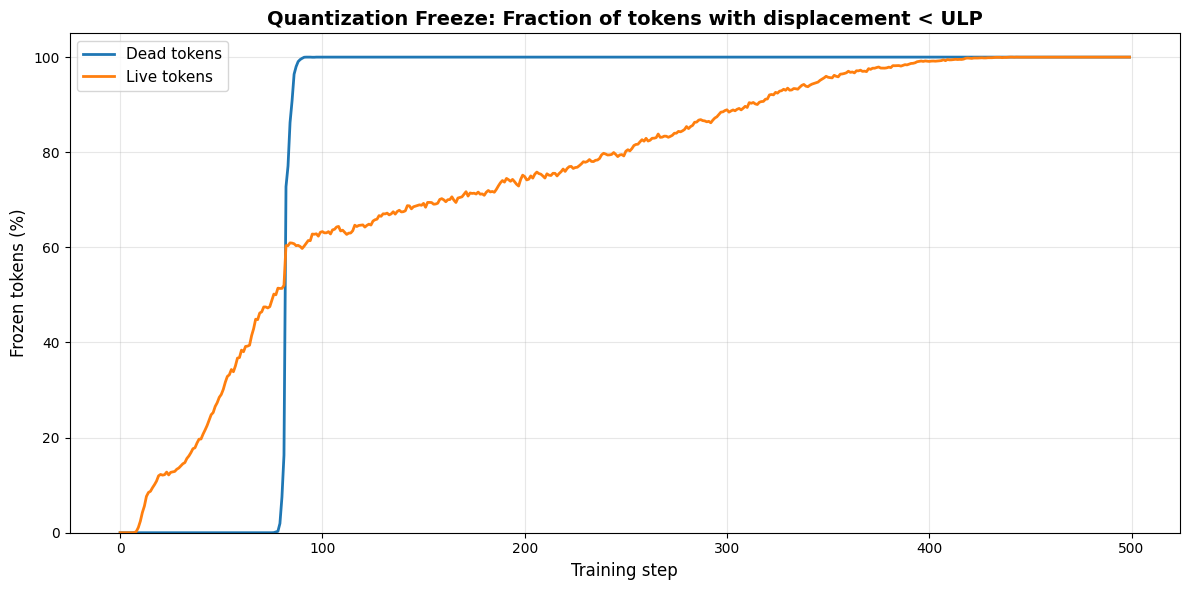


✓ Plotted freezing behavior over time


In [9]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

timesteps = np.arange(n_steps)

ax.plot(timesteps, 100 * frac_frozen_dead, label='Dead tokens', linewidth=2, color='C0')
ax.plot(timesteps, 100 * frac_frozen_live, label='Live tokens', linewidth=2, color='C1')

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Frozen tokens (%)', fontsize=12)
ax.set_title('Quantization Freeze: Fraction of tokens with displacement < ULP', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

print("\n✓ Plotted freezing behavior over time")

## Find Fimbulwinter Onset

In [10]:
# Define "Fimbulwinter" as when >90% of dead tokens are frozen
FREEZE_THRESHOLD = 0.90

fimbulwinter_onset = np.argmax(frac_frozen_dead >= FREEZE_THRESHOLD)

if frac_frozen_dead[fimbulwinter_onset] >= FREEZE_THRESHOLD:
    print(f"\n{'='*60}")
    print(f"FIMBULWINTER ONSET DETECTED")
    print(f"{'='*60}")
    print(f"Timestep: {fimbulwinter_onset}")
    print(f"Frozen fraction: {100*frac_frozen_dead[fimbulwinter_onset]:.1f}%")
    print(f"{'='*60}")
else:
    print(f"\nFimbulwinter not yet reached (max frozen: {100*frac_frozen_dead.max():.1f}%)")
    print(f"May need to extend training beyond {n_steps} steps.")


FIMBULWINTER ONSET DETECTED
Timestep: 85
Frozen fraction: 90.8%


## Detailed Analysis: When Did Tokens Freeze?

In [11]:
# For each dead token, find the FIRST timestep where it froze (and stayed frozen)
# "Stayed frozen" = frozen for at least 10 consecutive steps

CONSECUTIVE_FROZEN_THRESHOLD = 10

print(f"\nFinding when each dead token permanently froze...\n")

freeze_times = torch.full((n_dead,), -1, dtype=torch.long, device=device)

for token_idx in tqdm(range(n_dead), desc="Analyzing dead tokens"):
    frozen_history = frozen_dead[:, token_idx]  # Shape: (n_steps,)
    
    # Find first point where token stays frozen for CONSECUTIVE_FROZEN_THRESHOLD steps
    for t in range(n_steps - CONSECUTIVE_FROZEN_THRESHOLD):
        if frozen_history[t:t+CONSECUTIVE_FROZEN_THRESHOLD].all():
            freeze_times[token_idx] = t
            break

# Count how many never froze
never_froze = (freeze_times == -1).sum().item()
did_freeze = n_dead - never_froze

print(f"\n✓ Analysis complete")
print(f"  Tokens that froze: {did_freeze:,} / {n_dead:,} ({100*did_freeze/n_dead:.1f}%)")
print(f"  Tokens still moving: {never_froze:,}")

if did_freeze > 0:
    freeze_times_valid = freeze_times[freeze_times >= 0].cpu().numpy()
    print(f"\nFreeze timing statistics:")
    print(f"  Earliest freeze: t={freeze_times_valid.min()}")
    print(f"  Latest freeze: t={freeze_times_valid.max()}")
    print(f"  Median freeze: t={int(np.median(freeze_times_valid))}")


Finding when each dead token permanently froze...



Analyzing dead tokens: 100%|██████████| 3699/3699 [00:46<00:00, 79.46it/s]


✓ Analysis complete
  Tokens that froze: 3,699 / 3,699 (100.0%)
  Tokens still moving: 0

Freeze timing statistics:
  Earliest freeze: t=76
  Latest freeze: t=92
  Median freeze: t=82


## Plot: Histogram of Freeze Times

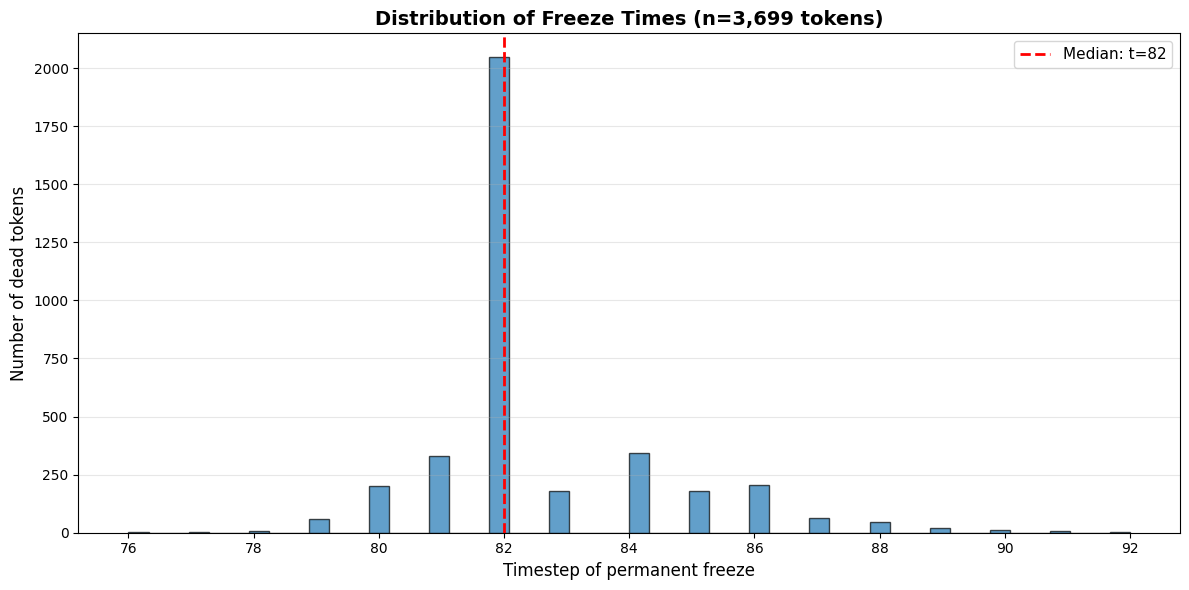

In [12]:
if did_freeze > 0:
    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
    
    ax.hist(freeze_times_valid, bins=50, color='C0', alpha=0.7, edgecolor='black')
    
    ax.set_xlabel('Timestep of permanent freeze', fontsize=12)
    ax.set_ylabel('Number of dead tokens', fontsize=12)
    ax.set_title(f'Distribution of Freeze Times (n={did_freeze:,} tokens)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Mark median
    median_freeze = int(np.median(freeze_times_valid))
    ax.axvline(median_freeze, color='red', linestyle='--', linewidth=2, label=f'Median: t={median_freeze}')
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
else:
    print("No tokens froze during this training run.")

## Summary

In [13]:
print(f"\n{'='*60}")
print(f"FLANNEL 7 FREEZING ANALYSIS SUMMARY")
print(f"{'='*60}\n")

print(f"Dataset: Flannel 7 ({n_steps} steps)")
print(f"Dead tokens: {n_dead:,}")
print(f"Live tokens: {n_live:,}")
print()

print(f"Freezing behavior:")
print(f"  Initial (t=0):  {100*frac_frozen_dead[0]:.1f}% dead, {100*frac_frozen_live[0]:.1f}% live")
print(f"  Final (t={n_steps-1}):   {100*frac_frozen_dead[-1]:.1f}% dead, {100*frac_frozen_live[-1]:.1f}% live")
print()

if frac_frozen_dead[fimbulwinter_onset] >= FREEZE_THRESHOLD:
    print(f"Fimbulwinter onset: t={fimbulwinter_onset} ({100*frac_frozen_dead[fimbulwinter_onset]:.1f}% frozen)")
else:
    print(f"Fimbulwinter not reached (max: {100*frac_frozen_dead.max():.1f}% frozen)")
print()

print(f"Permanent freeze analysis ({CONSECUTIVE_FROZEN_THRESHOLD}+ consecutive frozen steps):")
print(f"  Froze: {did_freeze:,} / {n_dead:,} ({100*did_freeze/n_dead:.1f}%)")
print(f"  Still moving: {never_froze:,}")

if did_freeze > 0:
    print(f"  Freeze timing: t={freeze_times_valid.min()} to t={freeze_times_valid.max()} (median: t={int(np.median(freeze_times_valid))})")

print(f"\n{'='*60}")


FLANNEL 7 FREEZING ANALYSIS SUMMARY

Dataset: Flannel 7 (500 steps)
Dead tokens: 3,699
Live tokens: 6,301

Freezing behavior:
  Initial (t=0):  0.0% dead, 0.0% live
  Final (t=499):   100.0% dead, 100.0% live

Fimbulwinter onset: t=85 (90.8% frozen)

Permanent freeze analysis (10+ consecutive frozen steps):
  Froze: 3,699 / 3,699 (100.0%)
  Still moving: 0
  Freeze timing: t=76 to t=92 (median: t=82)

